In [2]:
import numpy as np
import pandas as pd
import random

from trmf import trmf
from Forecast import AutoRegressionModel, NaiveModel, MeanModel
from RollingCV import RollingCV

import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Experiments on electricity data

#### 1. Experiment description:

** Models: ** Naive, Mean, AutoRegression and TRMF models;

** Lags: ** {1, 24};

** Forecast horizon: ** 1, 5, 10, 20;

** Metrics: ** Normalized deviation (ND), Normalized Root Mean Squared Error (NRMSE).

##### 2. Load data.

In [4]:
electricity = pd.read_table('../data/LD2011_2014.txt', sep=';', decimal=',')

In [5]:
# transpose and sum by hours
data = electricity.values[:,1:].T.reshape((35064*370,4)).sum(axis=1).reshape((370,35064))[:,10064:].astype(float)[:, -750:]
data.shape

(370, 750)

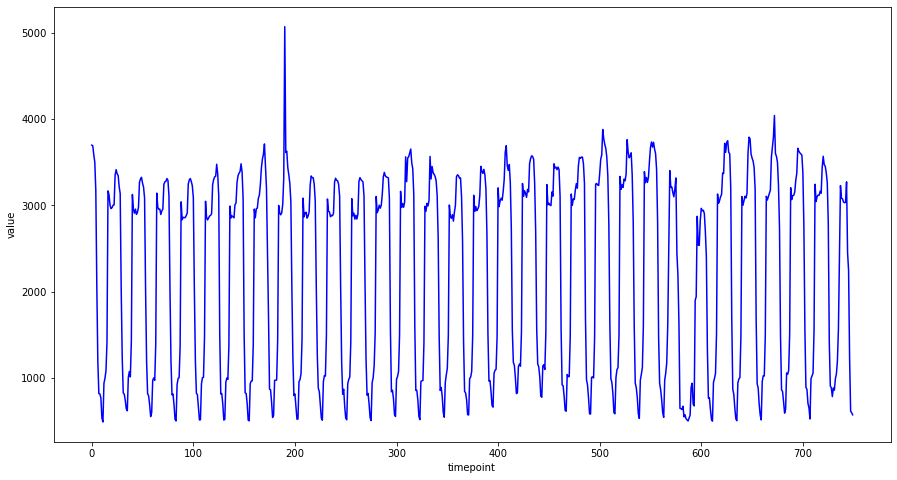

In [6]:
plt.figure(figsize=(15,8))
plt.plot(data[100], color='blue')

plt.xlabel('timepoint')
plt.ylabel('value')

plt.show()

In [7]:
N = 370
T = 750
K = 8
lags = [1, 24]
L = len(lags)

##### 3. Apply models

In [12]:
# Naive model
for h in [1, 5, 10, 20]:
    model = NaiveModel()
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='MAE')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('Naive model performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                                    round(np.array(scores_nrmse).mean(),3)))

Naive model performance ND/NRMSE (h = 1): 0.343/0.5
Naive model performance ND/NRMSE (h = 5): 0.678/0.951
Naive model performance ND/NRMSE (h = 10): 0.951/1.429
Naive model performance ND/NRMSE (h = 20): 1.217/1.73


In [10]:
# Mean model
for h in [1, 5, 10, 20]:
    model = MeanModel()
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('Mean model performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                          round(np.array(scores_nrmse).mean(),3)))

Mean model performance ND/NRMSE (h = 1): 1.0/1.19
Mean model performance ND/NRMSE (h = 5): 1.0/1.201
Mean model performance ND/NRMSE (h = 10): 1.0/1.204
Mean model performance ND/NRMSE (h = 20): 1.0/1.188


In [17]:
# AR model
for h in [1, 5, 10, 20]:
    model = AutoRegressionModel(lags)
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('AR performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                           round(np.array(scores_nrmse).mean(),3)))

AR performance ND/NRMSE (h = 1): 0.427/0.557
AR performance ND/NRMSE (h = 5): 0.612/0.831
AR performance ND/NRMSE (h = 10): 0.627/0.876
AR performance ND/NRMSE (h = 20): 0.58/0.802


In [13]:
# TRMF model
lambda_f = 1.
lambda_x = 1.
lambda_w = 1.
eta = 1.
alpha = 1000.
max_iter = 1000

for h in [1, 5, 10, 20]:
    model = trmf(lags, K, lambda_f, lambda_x, lambda_w, alpha, eta, max_iter)
    scores_nd = RollingCV(model, data, T-9-h, h, T_step=1, metric='ND')
    scores_nrmse = RollingCV(model, data, T-9-h, h, T_step=1, metric='NRMSE')
    print('TRMF performance ND/NRMSE (h = {}): {}/{}'.format(h, round(np.array(scores_nd).mean(),3),\
                                                    round(np.array(scores_nrmse).mean(),3)))

TRMF performance ND/NRMSE (h = 1): 0.624/0.812
TRMF performance ND/NRMSE (h = 5): 0.726/0.955
TRMF performance ND/NRMSE (h = 10): 0.667/0.927
TRMF performance ND/NRMSE (h = 20): 0.579/0.806


### Results Electricity Data (ND/NRMSE)

| | h=1 | h=5 | h=10 | h=20 ||
|------|------|------|------|
| Naive | **0.344/0.5** | 0.688/0.951 | 1.091/1.429 | 1.363/1.73 |
| Mean | 1.0/1.19 | 1.0/1.201 | 1.0/1.204 | 1.0/1.188 |
| AutoRegression | 0.427/0.557 | **0.612/0.831** | **0.627/0.876** | **0.58**/0.802 |
| TRMF | 0.639/0.828 | 0.727/0.95 | 0.681/0.936 | 0.584/**0.799** |
